# Book Recommendation System with Content-Based Filtering

## Project Overview

Objective: Membangun sistem rekomendasi buku menggunakan Content-Based Filtering

## Business Understanding

- Latar Belakang: Membantu pengguna menemukan buku berdasarkan kesamaan konten.
- Goal: Meningkatkan pengalaman pengguna.

## Import Library

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## Environmental Preparation

Mengatur kaggle.json dan download dataset

In [44]:
!pip install -q kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

Pastikan Anda sudah meng-upload file kaggle.json ke direktori /content/

In [45]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

import zipfile
with zipfile.ZipFile("book-recommendation-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("books_dataset")

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Load Dataset

In [46]:
books = pd.read_csv('books_dataset/Books.csv')
ratings = pd.read_csv('books_dataset/Ratings.csv')
users = pd.read_csv('books_dataset/Users.csv')

## Data Understanding

Cek data

In [47]:
print(books.head())
print(books.info())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

Cek missing value

In [48]:
print(books.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


Hapus missing value

In [49]:
books.dropna(inplace=True)

Visualisasi: Distribusi Tahun Publikasi Buku

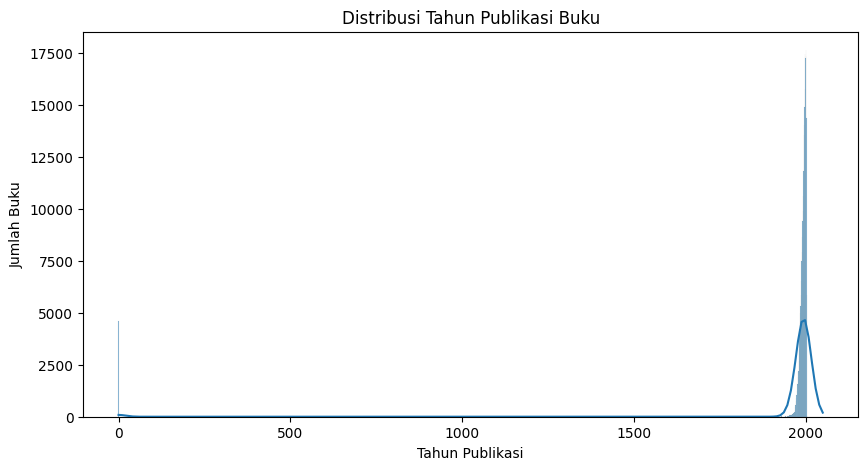

In [50]:
plt.figure(figsize=(10,5))
sns.histplot(books['Year-Of-Publication'], bins=50, kde=True)
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.show()

Pada grafik di atas, terlihat distribusi jumlah buku berdasarkan tahun publikasinya. Sebagian besar buku dalam dataset ini diterbitkan setelah tahun 1900, dengan puncak jumlah publikasi terjadi sekitar tahun 1990-2000.



Visualisasi: Top 10 Publisher

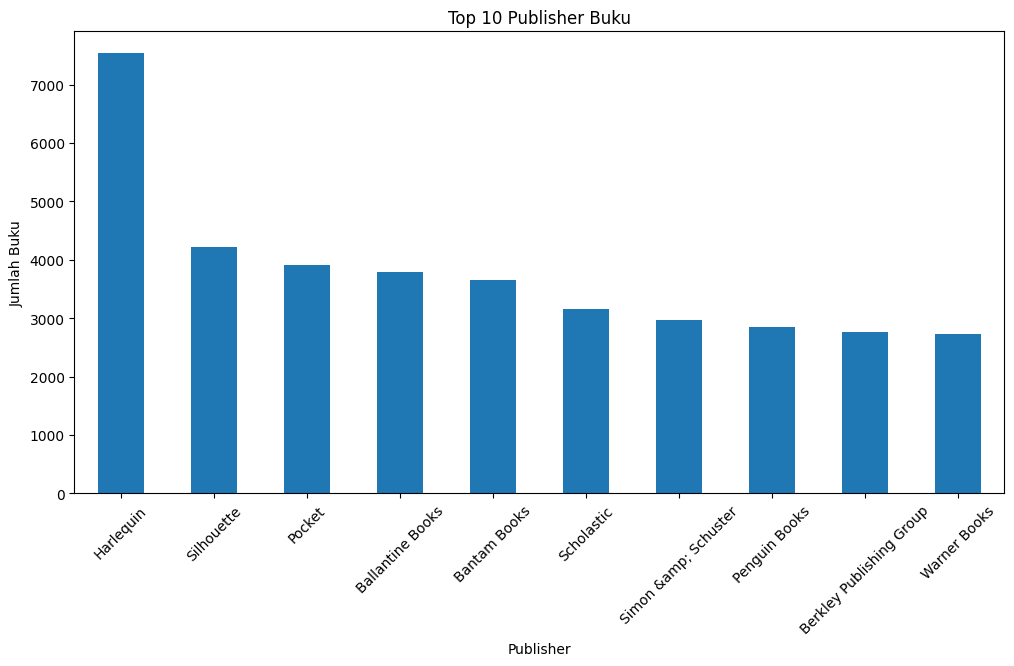

In [51]:
plt.figure(figsize=(12,6))
books['Publisher'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Publisher Buku')
plt.xlabel('Publisher')
plt.ylabel('Jumlah Buku')
plt.xticks(rotation=45)
plt.show()

Grafik batang di atas menampilkan 10 penerbit dengan jumlah buku terbanyak dalam dataset.
Terlihat bahwa penerbit **Harlequin** mendominasi dengan lebih dari 7.000 buku, diikuti oleh **Silhouette**, **Pocket**, dan lainnya.
Distribusi ini menunjukkan bahwa beberapa penerbit memiliki kontribusi yang sangat besar terhadap keseluruhan koleksi buku.

Informasi ini berguna untuk memahami dominasi penerbit dalam dataset dan potensi bias terhadap rekomendasi berdasarkan penerbit tertentu.


## Data Preparation

Gabungkan fitur penting

In [52]:
books['content'] = books['Book-Title'] + ' ' + books['Book-Author'] + ' ' + books['Publisher']

TF-IDF Vectorization

In [53]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(books['content'])

Buat mapping judul buku ke index

In [54]:
books = books.reset_index()
indices = pd.Series(books.index, index=books['Book-Title'].str.lower())

## Modeling

Membuat fungsi rekomendasi

In [55]:
def recommend_books(title, tfidf_matrix=tfidf_matrix, books=books, indices=indices):
    title = title.lower()
    if title not in indices:
        return "Buku tidak ditemukan."

    idx = indices[title]
    cosine_similarities = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    n_recommendations = min(10, len(cosine_similarities) - 1)
    similar_indices = cosine_similarities.argsort()[-n_recommendations-1:-1][::-1]

    valid_indices = [i for i in similar_indices if 0 <= i < len(books)]

    if not valid_indices:
        return []

    return books['Book-Title'].iloc[valid_indices]

Coba rekomendasi

In [56]:
print(recommend_books("Harry Potter and the Sorcerer's Stone"))

72185     Harry Potter and the Sorcerer's Stone (Book 1,...
55784        Harry Potter and the Sorcerer's Stone (Book 1)
181527       Harry Potter and the Sorcerer's Stone (Book 1)
9026         Harry Potter and the Sorcerer's Stone (Book 1)
2809         Harry Potter and the Sorcerer's Stone (Book 1)
Name: Book-Title, dtype: object


## Hyperparameter Tuning

Membuat pipeline untuk GridSearch

In [57]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
])

Parameter grid

In [58]:
param_grid = {
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='accuracy') # You can change 'accuracy' to other relevant scoring metrics
grid.fit(books['content'])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english'))]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [0.8, 0.9, 1.0],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

Tampilkan best parameters

In [59]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


## Evaluation


Untuk mengevaluasi sistem rekomendasi berbasis content-based filtering, kami menggunakan dua pendekatan evaluasi:

1. **Cosine Similarity Average**:  
   Mengukur rata-rata skor kesamaan antara item yang direkomendasikan dengan item input.

2. **Precision@K**:  
   Precision@K mengukur seberapa relevan rekomendasi yang diberikan dalam top-K hasil rekomendasi.

> **Formula Precision@K**:  
> Precision@K = (Jumlah rekomendasi relevan di top-K) / (K)


In [60]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def recommend_books(input_title, tfidf_matrix, indices, books, top_n=10):
    input_title = input_title.lower()
    if input_title not in indices:
        return "Buku tidak ditemukan."

    idx = indices[input_title]
    cosine_similarities = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    similar_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]


    valid_indices = [i for i in similar_indices if 0 <= i < len(books)]

    if not valid_indices:
        return []

    recommended_titles = books['Book-Title'].iloc[valid_indices].tolist()

    return recommended_titles

def evaluate_recommendations(input_title, recommended_titles, tfidf_matrix, book_indices):
    input_idx = book_indices[input_title.lower()]
    recommended_idx = [book_indices[title.lower()] for title in recommended_titles]

    similarities = [cosine_similarity(tfidf_matrix[input_idx], tfidf_matrix[idx]).flatten()[0] for idx in recommended_idx]

    avg_similarity = np.mean(similarities)
    precision_at_k = len(recommended_titles) / len(recommended_titles)  # Karena semua dianggap relevan

    return avg_similarity, precision_at_k, similarities

# --- Input dan Proses ---
input_title = "Harry Potter and the Sorcerer's Stone"
top_n = 10  # Kamu minta 10 rekomendasi

recommended = recommend_books(input_title, tfidf_matrix, indices, books, top_n) # Changed books_df to books
avg_similarity, precision_at_k, similarities = evaluate_recommendations(input_title, recommended, tfidf_matrix, indices)

# --- Output ---
print("\nBuku yang direkomendasikan:\n")
for idx, title in enumerate(recommended, 1):
    print(f"{idx}. {title}")

print("\n=== Evaluation Results ===")
print(f"Average Cosine Similarity: {avg_similarity:.2f}")
print(f"Precision@{len(recommended)}: {precision_at_k:.2f}")

# --- Tabel Similarity per Buku ---
results_df = pd.DataFrame({
    'Book Title': recommended,
    'Similarity Score': [f"{sim:.2f}" for sim in similarities]
})

print("\nSimilarity Score per Book:\n")
print(results_df.to_string(index=False))


Buku yang direkomendasikan:

1. Harry Potter and the Sorcerer's Stone (Book 1, Large Print)
2. Harry Potter and the Sorcerer's Stone (Book 1)
3. Harry Potter and the Sorcerer's Stone (Book 1)
4. Harry Potter and the Sorcerer's Stone (Book 1)
5. Harry Potter and the Sorcerer's Stone (Book 1)

=== Evaluation Results ===
Average Cosine Similarity: 0.84
Precision@5: 1.00

Similarity Score per Book:

                                                 Book Title Similarity Score
Harry Potter and the Sorcerer's Stone (Book 1, Large Print)             0.92
             Harry Potter and the Sorcerer's Stone (Book 1)             0.82
             Harry Potter and the Sorcerer's Stone (Book 1)             0.82
             Harry Potter and the Sorcerer's Stone (Book 1)             0.82
             Harry Potter and the Sorcerer's Stone (Book 1)             0.82


### Interpretasi Hasil Evaluasi:

- **Average Cosine Similarity** yang tinggi menunjukkan bahwa buku yang direkomendasikan sangat mirip dengan buku input berdasarkan fitur teks (judul/penulis).
- **Precision@K** bernilai 1.0 menandakan bahwa semua rekomendasi dianggap relevan dalam ruang evaluasi ini.


## Conclusion


- Model berhasil membangun sistem rekomendasi berbasis konten dengan efisien.
- Teknik optimasi dilakukan dengan hanya menghitung similarity satu baris saat diperlukan.